# Dual Rate Spring System

A dual rate system consists of two coil springs in series (main and tender) and a crossover ring which dictates the transition between the equivalent rate of the two springs to the higher spring rate of the main spring. The main point of using dual rate systems is to achieve better ride control without bottoming the suspension on jumps. 

The equivalent spring rate is given by 
$
\begin{align}
k_{eq} = \frac{k_{main} k_{tender}}{k_{main}+k_{tender}}
\bigg[  \frac{\mbox{lb}}{\mbox{in}} \bigg]
\end{align}
$
where:

$k_{main}$ is the main spring rate [lb/in]

$k_{tender}$ is the tender spring rate [lb/in]

First, let's load input data to rollout some calculations:

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [4]:
def import_file():
    spring_input = pd.read_excel('spring_input.xlsx', index_col=0, header=None, usecols = "A,C:AA", skiprows=0).transpose()
    vehicle_input = pd.read_excel('vehicle_input.xlsx', index_col=0, header=None, usecols = "A,C:AA", skiprows=0).transpose()
    # calculates the equivalent spring coefficient k_eq:
    spring_input['k_eq'] = (spring_input['k_main']*spring_input['k_tender']) / (spring_input['k_main']+spring_input['k_tender'])
    # converts the spring coefficients from lb/in to N/mm
    lb_in2N_mm = 0.017858*9.81
    for convert_to_SI in ['k_tender', 'k_main', 'k_eq']:
        spring_input[convert_to_SI + str('_SI')] = spring_input[convert_to_SI]*lb_in2N_mm
    
    return spring_input, vehicle_input

In [ ]:
spring_input, vehicle_input = import_file()

In [ ]:
spring_input

In [ ]:
vehicle_input

The force and the system displacement are related by the equation:

$
\begin{align}
F_{s} = \left \{ \begin{matrix} k_{eq}x, & \mbox{if } x \le x_{crossover} \\ 
k_{main}x, & \mbox{if } x > x_{crossover} \end{matrix} \right.
\end{align}
$

Where:

- $F_{s}$ is the spring froce [N];
- $x$ is the displacement of the system [mm];
- $x_{crossover}$ is the crossover distance [mm].

$x_{crossover}$ occurs when the slider hits the crossover ring and from that point only the main spring is compressed. This point is where the force of the equivalent system compresses the tender spring by the amount of the crossover ring distance set with the damper at full rebound.


$
\begin{align}
F_{crossover} = k_{tender}x_{crossover\_ring}
\end{align}
$

Thus, the $x_{crossover}$ is given by the equation:

$
\begin{align}
x_{crossover} = \frac{F_{crossover}}{k_{eq}} = \frac{k_{tender}x_{crossover\_ring}}{k_{eq}}
\end{align}
$


In [48]:
def dual_rate_spring_system():
    spring_input, vehicle_input = import_file()
    spring_system = pd.DataFrame()
    g = 9.81 # [m/s^2]
    
    for setup in range(1, len(spring_input) + 1):
        data_temp = spring_input[spring_input['setup'] == setup]
        spring_force = []
        displacement_step = 0.1
        df = pd.DataFrame()
        # crossover point
        x_crossover =  int(data_temp['k_tender_SI'] * data_temp['crossover_ring'] / data_temp['k_eq_SI'])
        # spring travel available
        x_main = data_temp['L_main_free'] - data_temp['L_main_block']
        x_tender = data_temp['L_tender_free'] - data_temp['L_tender_block']
        # force due to preload
        F_preload = data_temp['preload'] * data_temp['k_eq_SI']
        # compression due to preload
        x_preload_main = (data_temp['k_eq_SI'] / data_temp['k_main_SI']) * data_temp['preload']
        x_preload_tender = (data_temp['k_eq_SI'] / data_temp['k_tender_SI']) * data_temp['preload']
        # spring displacement range
        df['displacement'] = np.arange(0, int((x_main - x_preload_main + x_tender - x_preload_tender)) 
                                       + displacement_step , displacement_step)
        # calculates the spring force
        for displacement in df['displacement']:
            if displacement < x_crossover:
                spring_force.append(displacement*int(data_temp['k_eq_SI'])+ int(F_preload))
            else:
                spring_force.append(spring_force[-1] + displacement_step*int(data_temp['k_main_SI']))
        df['spring_force'] = spring_force
        df['setup'] = setup
        spring_system = spring_system.append(df)
        
    return spring_system

In [49]:
def plot_dual_rate_chart(setup, title):
    
    dual_rate_spring_system()
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(1,1,1)

    for i in setup:
        ax.plot('displacement', 'spring_force', data = spring_system[spring_system['setup']==i], 
                label = (str(int(spring_input.loc[spring_input.setup == i]['k_main']))) + 
                ' / ' + str(int(spring_input.loc[spring_input.setup == i]['k_tender'])) + 
                ' (crossover = ' + str(int(spring_input.loc[spring_input.setup == i]['crossover_ring'])) + 
                'mm, preload = ' + str(int(spring_input.loc[spring_input.setup == i]['preload'])) + 'mm)')
    ax.legend()
    ax.set_title(title)
    ax.set_xlabel('Displacement [mm]')
    ax.set_ylabel('Force [N]')
    ax.grid(linestyle=':', linewidth=0.3)

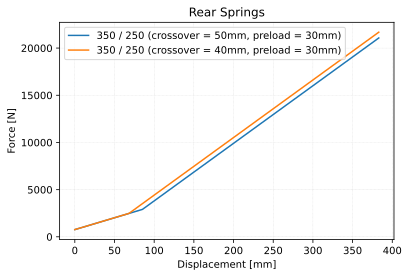

In [50]:
setup = [1,2]
plot_dual_rate_chart(setup, 'Rear Springs')

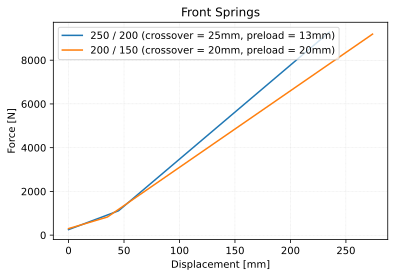

In [51]:
setup = [5,6]
plot_dual_rate_chart(setup, 'Front Springs')

## function *coil_bind* 

Inputs:
- $K_{main}$ main spring rate [lb/in]
- $L_{main\_free}$ main spring free length [mm]
- $L_{main\_block}$ main spring block length [mm]


- $K_{tender}$ tender spring rate [lb/in]
- $L_{tender\_free}$ tender spring free length [mm]
- $L_{tender\_block}$ tender spring block length [mm]


- $L_{damper\_extended}$ extended length with limit straps race ready [mm]
- $L_{damper\_compressed}$ compressed length without bump rubber as spec sheet [mm]
- $L_{damper\_RH}$ damper length at ride height race ready [mm]


- $x_{spring\_preload}$ spring preload [mm]

Ouputs:
- $x_{min\_crossover\_ring}$ minimum crossover ring clearance at ride height to avoid main spring coil bind [mm]
- $L_{main\_RH}$ main spring length at ride height [mm]


$
L_{main\_RH} = L_{main\_free} - \frac{K_{eq}}{K_{main}}(L_{damper\_extended} - L_{damper\_RH}) - 
\frac{K_{eq}}{K_{main}}(x_{spring\_preload})
$

The minimum crossover ring to keep the main spring from coil bind is given by the linear system of equations below:

$x_1 + x_2\frac{K_{main}}{K_{eq}} = L_{damper\_RH} - L_{damper\_compressed}$

$x_1 + x_2 = L_{main\_RH} - L_{main\_block}$

where, 

- $x_1$ is the main sping travel with $K_{main}$ i.e. after the slider hits the crossover ring
- $x_2 = x_{min\_crossover\_ring}$ to keep the main spring from coil bind

Isolating $x_1$ we have:

$x_1 = \frac{(L_{damper\_RH} - L_{damper\_compressed})-(L_{main\_RH} - L_{main\_block})\frac{K_{main}}{K_{eq}}}{[1-\frac{K_{main}}{K_{eq}}]}$

which gives

$x_2 = L_{main\_RH} - L_{main\_block} - x_1$ 



In [53]:
def coil_bind(file, setup):
    spring_input = pd.read_excel(file, index_col=0, header=None, usecols = "A,C:AA", skiprows=0).transpose()
    spring_input = spring_input[spring_input['setup'] == setup]
    
    x_min_crossover_ring = []
    L_main_ride_height = []
    lb_in2N_mm = 0.017858*9.81
    k_main = spring_input['k_main']
    k_main_SI = k_main*lb_in2N_mm
    L_main_free = spring_input['L_main_free']
    L_main_block = spring_input['L_main_block']
    k_tender = spring_input['k_tender']
    k_tender_SI = k_tender*lb_in2N_mm
    L_tender_free = spring_input['L_tender_free']
    L_tender_block = spring_input['L_tender_block']
    L_damper_extended = spring_input['L_damper_extended']
    L_damper_compressed = spring_input['L_damper_compressed']
    L_damper_ride_height = spring_input['L_damper_ride_height']
    k_eq = k_main*k_tender / (k_main + k_tender)
    k_eq_SI = k_eq*lb_in2N_mm
    x_spring_preload = spring_input['preload']

    L_main_ride_height.append((L_main_free - (k_eq/k_main) * (L_damper_extended - L_damper_ride_height) 
                      - (k_eq/k_main) * x_spring_preload))
    x1 = ((L_damper_ride_height - L_damper_compressed)-(L_main_ride_height[-1] - L_main_block) * 
          (k_main / k_eq))/(1-(k_main/k_eq))
    x_min_crossover_ring = L_main_ride_height[-1] - L_main_block - x1
    print('x1 is equal to ',x1)
    print('L_damper_ride_height ', L_damper_ride_height)
    print('L_main_ride_height ', L_main_ride_height[-1])
    print('x_spring_preload ', x_spring_preload)

    return x_min_crossover_ring

In [55]:
setup = 4
file = 'spring_input.xlsx'
coil_bind(file, setup)

x1 is equal to  5    20.65
dtype: object
L_damper_ride_height  5    520
Name: L_damper_ride_height, dtype: object
L_main_ride_height  5    102.178
dtype: object
x_spring_preload  5    13
Name: preload, dtype: object


5    34.5378
dtype: object

# Longitudinal Load Transfer

In [ ]:
vehicle_input = pd.read_excel('vehicle_input.xlsx', header = 1)

vehicle_input

Longitudinal load transfer $\Delta W_x$ is given by:

$
\begin{align}
\Delta W_x = ma_x \frac{h_{cg}}{L_{wb}}
\end{align}
$

where,

- $m$ is the total mass of the vehicle [kg]
- $a_x$ is the logitudinal acceleration [m/s²]
- $h_{cg}$ is the C.G height [mm]
- $L_{wb}$ is the vehicle wheelbase [mm]

Thus, the weight on front $W_{front}$ and rear axle $W_{rear}$ for a given logitudinal
acceleration $a_x$ is:

$
\begin{align}
W_{front} = mg\frac{L_1}{L_{wb}} - ma_x \frac{h_{cg}}{L_{wb}}
\end{align}
$



$
\begin{align}
W_{rear} = mg\frac{L_2}{L_{wb}} + ma_x \frac{h_{cg}}{L_{wb}}
\end{align}
$

where,

- $L_1$ is the distance between the C.G and the front axle [mm]
- $L_2$ is the distance between the C.G and the rear axle [mm]

In [ ]:
vehicle_input['L_1'] = vehicle_input['L_wheelbase'] * (1 - vehicle_input['rear_mass_distribution'])
vehicle_input['L_2'] = vehicle_input['L_wheelbase'] - vehicle_input['L_1']

DeltaW_x = pd.DataFrame()

W_total = int(vehicle_input['W_total'])
h_cg = int(vehicle_input['h_cg'])
L_wheelbase = int(vehicle_input['L_wheelbase'])

DeltaW_x['ax'] = np.arange(0,2,0.25)
DeltaW_x['load_transfer'] = DeltaW_x['ax'] * W_total * h_cg / L_wheelbase

fig =  plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot('ax', 'load_transfer', data = DeltaW_x)
ax.set_xlabel('$a_x$ [g\'s]')
ax.set_ylabel('$\Delta W_x$ [N]')
ax.grid(linestyle=':', linewidth=0.3)

For a given longitudinal aceleration there is a corresponding longitudinal weight transfer which compresses the rear spring and extends the front spring. Thus, the dual rate spring system can be related with the longitudinal acceleration by the given formula:

$
\begin{align}
a_x = \frac{FL_{wb}}{m h_{cg}}
\end{align}
$

In [ ]:
spring_system['ax'] = spring_system['spring_force'] * L_wheelbase /  (W_total * h_cg * 9.81)

spring_system.head()

In [ ]:
fig = plt.figure(figsize=(6,4))

ax = fig.add_subplot(1,1,1)


for setup in range(1, len(spring_input) + 1):

    ax.plot('ax', 'displacement', data = spring_system[spring_system['setup']==setup])


    
#ax.legend()
ax.set_xlabel('$a_x$ [g\'s]')
ax.set_ylabel('Displacement [mm]')
ax.grid(linestyle=':', linewidth=0.3)